## Loading the model and running batch predictions locally

This scripts load the previously trained model and uses it to predict the class of a new set of images.

The images were taken from another [Kaggle dataset](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri). I downloaded the data and used the "no-tumour" folders and the "glioma_tomor" folders as the "no" and "yes" folders under the "predict folder".



In [4]:
## install tensorflow to train CNN
!pip install tensorflow

## install opencv to manipulate images
# !pip install opencv-python
# For Sagemeaker:
!pip uninstall opencv-python --yes
!pip install opencv-python-headless

  Using cached tensorflow-2.11.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (588.3 MB)
  Using cached tensorboard-2.11.2-py3-none-any.whl (6.0 MB)
  Using cached protobuf-3.19.6-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached flatbuffers-23.3.3-py2.py3-none-any.whl (26 kB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.4 MB)
  Using cached libclang-15.0.6.1-py2.py3-none-manylinux2010_x86_64.whl (21.5 MB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached grpcio-1.51.3-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.8 MB)
  Using cached termcolor-2

In [6]:
## current folder structure:

folder_edited = """

├── code  
└── dataset  
    └── brain-mri-images-for-brain-tumor-detection  
        └── brain_tumor_dataset  
            └── raw
                ├── no  
                └── yes
            └── processed
                ├── no  
                └── yes
            └── augmented
                ├── no  
                └── yes
            └── predict
                ├── no  
                └── yes
"""


In [7]:
## load libraries

import os
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [8]:
## load functions for processing data


def zero_runs(arr):
    """function that detects consecutive zeros"""
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(arr, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges


def crop_img(img, threshold=0.1):
    """function that crops an array based on a threshold"""
    img_len, img_width = img.shape
    x_min, y_min, x_max, y_max = 0, 0, img_width, img_len
    mask = img > threshold
    bounds_x = zero_runs(mask.sum(axis=0))
    bounds_y = zero_runs(mask.sum(axis=1))
    # if there are zero runs, check if they start at 0 and end at image len
    if bounds_x.size != 0:
        if bounds_x[0][0] == 0:
            x_min = bounds_x[0][1]

        if bounds_x[-1][1] == x_max:
            x_max = bounds_x[-1][0]

    if bounds_y.size != 0:
        if bounds_y[0][0] == 0:
            y_min = bounds_y[0][1]

        if bounds_y[-1][1] == y_max:
            y_max = bounds_y[-1][0]

    return img[y_min:y_max, x_min:x_max]


def process_img(img, img_size = (200, 200)):
    """function that processes the images.
    It converts them to gray scale with 1 channel only.
    It scales them to 0-1, crops negative space around them and resizes them"""
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_grey_norm = (img_grey / 255)
    img_grey_cropped = crop_img(img_grey_norm)
    img_grey_std = cv2.resize(img_grey_cropped, img_size)
    return img_grey_std

def shuffled_data(X, y):
    """function to shuffle data X and labels y"""
    idx = np.random.permutation(len(X))
    return X[idx], y[idx]


In [9]:
## load images for predictions
img_extention = (".jpg")
dataset_dir = "../dataset/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/"

## normal scans paths
neg_prd_imgs_dir = os.path.join(dataset_dir, "predict/no")
neg_imgs_path = [os.path.join(neg_prd_imgs_dir, file) for file in os.listdir(neg_prd_imgs_dir) if file.lower().endswith(img_extention)]

## brain cancer scans paths
pos_prd_imgs_dir = os.path.join(dataset_dir, "predict/yes")
pos_imgs_path = [os.path.join(pos_prd_imgs_dir, file) for file in os.listdir(pos_prd_imgs_dir) if file.lower().endswith(img_extention)]

def load_process(imgs_path):
    data = []
    for img_path in imgs_path:
        img = cv2.imread(img_path)
        img = process_img(img)
        ## retrun back to 3 channel array which the model expects
        img = cv2.merge((img,img,img))
        data.append(img)
    return np.array(data)


## load and prcoess negative data:
neg_data = load_process(neg_imgs_path)
neg_labels = [0] * len(neg_data)


## load and process positive data:
pos_data = load_process(pos_imgs_path)
pos_labels = [1] * len(pos_data)

## merge data:

X_data = np.concatenate((neg_data, pos_data), axis=0)
y_labels = np.concatenate((neg_labels, pos_labels), axis=0)

X_prd, y_prd = shuffled_data(X_data, y_labels)
                 

In [10]:
X_prd.shape

(41, 200, 200, 3)

In [11]:
## visualize images:

def plot_sample_imgs(imgs, labels, num_samples, title=""):
    fig, ax = plt.subplots(2, num_samples, figsize=(num_samples*2, num_samples))
    if title:
        fig.suptitle(title)
    for k in range(num_samples*2):
        i, j = k//num_samples, k%num_samples
        ax[i, j].imshow(imgs[k])
        ax[i, j].set_title(labels[k])
        ax[i, j].axis("off")
    plt.show()

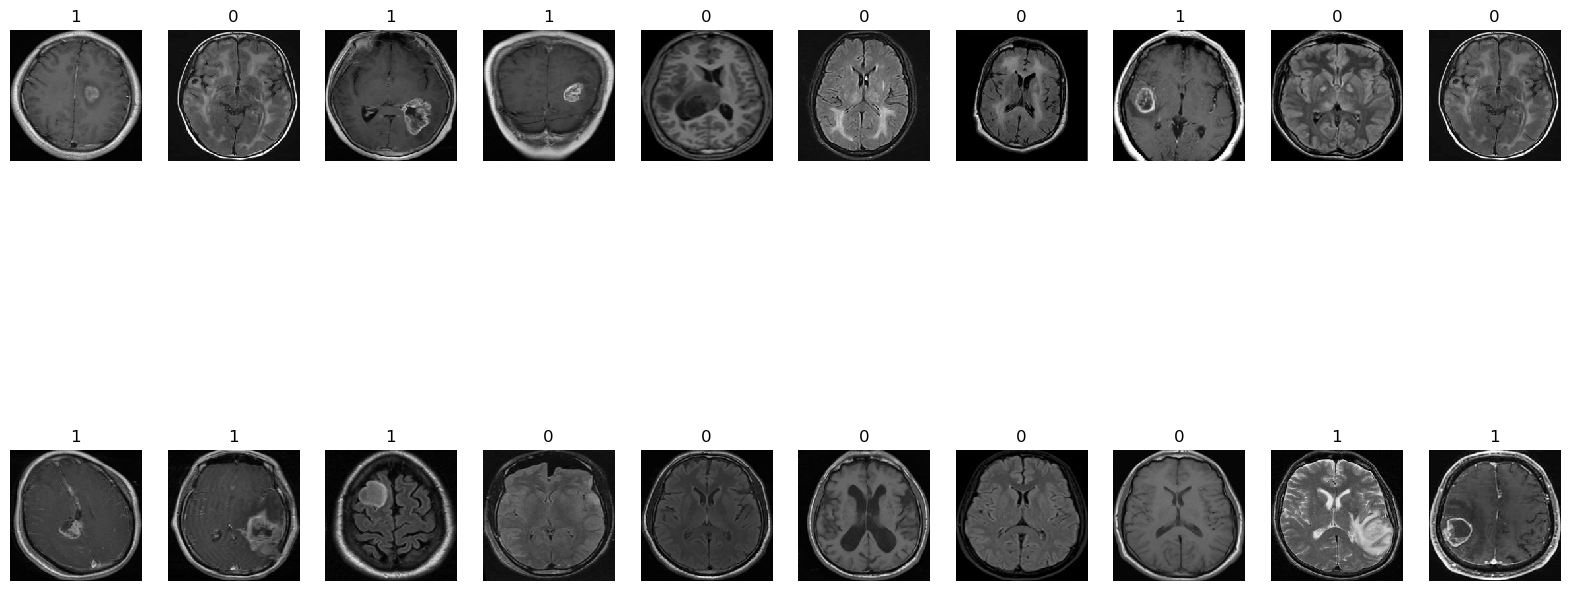

In [12]:
plot_sample_imgs(X_prd, y_prd, 10, title="")

In [13]:
X_prd.shape

(41, 200, 200, 3)

images seem to be cropped and resized well. Some images are not. The cropping removes pixel intensities of 0. If the background in these images are not zero due to difference in machine settings or processing then the processing will not be consistent. It is very important that the model be trained on an image set from the same condidtions as the prediction set. This is not the case here since there was not enough images and new images were taken from another source. But in production, you want to train your model on data that comes from the same conditions as the data you would like to predict.

In [14]:
## load model

mdl_output = "detectBC_binaryC_model_v1.pkl"

model = pickle.load(open(mdl_output, "rb"))

Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-03-03 21:16:34           64
config.json                                    2023-03-03 21:16:34        10418
variables.h5                                   2023-03-03 21:16:34    115555488
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_10
.........vars
............0
............1
......conv2d_11
.........vars
............0
............1
......conv2d_12
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......conv2d_4
.........vars
............0
............1
......conv2d_5
.........vars
............0
............1
......conv2d_6
.........vars
............0
............1
....

In [15]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 50, 50, 256)      

In [16]:
%%time

## run predictions

predictions_prb = model.predict(X_prd, verbose=0)
predictions = [1 if num > 0.5 else 0 for num in predictions_prb]


CPU times: user 17.4 s, sys: 1.37 s, total: 18.8 s
Wall time: 20.8 s


In [17]:
predictions_prb.shape

(41, 1)

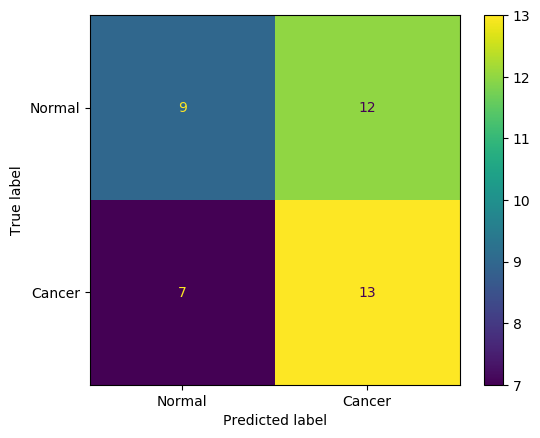

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cfn_mat = confusion_matrix(y_labels, predictions)

cfn_plt = ConfusionMatrixDisplay(confusion_matrix=cfn_mat, display_labels=["Normal", "Cancer"])
cfn_plt.plot()
plt.show()

In [19]:
## look at model metrics:
print("Precision = " + str(precision_score(y_labels, predictions)))
print("Recall = " + str(recall_score(y_labels, predictions)))
print("Accuracy = " + str(accuracy_score(y_labels, predictions)))


Precision = 0.52
Recall = 0.65
Accuracy = 0.5365853658536586


The model is not performing well on these set of images, possibly because they come from a different dataset with different properties. 